In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.integrate
from collections import Counter
from scipy.optimize import curve_fit
import os

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

In [2]:
def watershed(filename, lbox=1, nside=1):
    f = h5py.File(filename, 'r')
    watershed = f['watershed_group'][...]
    f.close()
    counts = Counter(watershed.flatten())
    clusters = np.array(list(counts.items()))
    cluster_n_size = clusters[:,1]
    cluster_radius = (3.0*(cluster_n_size*(lbox/nside)**3)/(4.0*np.pi))**(1/3)
    return {'mean_radius':np.mean(cluster_radius), 'std_radius':np.std(cluster_radius), 
            'N':len(cluster_n_size), 'max_radius':np.max(cluster_radius)}

In [9]:
def summary_watershed(data, path="./", name="nbody", 
                          vmax=None, lbox=1.0, nside=1, sigmas=[1]):
    experiment_name = "{}_{}_{}".format(name, lbox, nside)
    data[experiment_name] = {}
    data[experiment_name]["nside"] = nside
    data[experiment_name]["name"] = name
    data[experiment_name]["lbox"] = lbox
    data[experiment_name]["sigmas"] = sigmas
    
    for sigma in sigmas:
        if name=="nbody":
            filename = "watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_{:.1f}_s_{:.1f}_nside_{}.hdf5".format(vmax, sigma, int(nside))
        elif name=="gauss":
            filename = "watershed_mock_divergence_mesh_{}_box_{}_slim_{}.h5".format(int(nside), int(lbox), int(sigma))       
        filename = os.path.join(path, filename)
        print(experiment_name, sigma)
        data[experiment_name][sigma] = watershed(filename, lbox=lbox, nside=nside)
    
    return 

In [10]:
def write_watershed(data, experiment):
    filename = "watershed_{}.dat".format(experiment)
    print(filename)
    f = open(filename, "w")
    for sigma in data[experiment]["sigmas"]:
        f.write("{} {:.2f} {:.2f} {:d} {:.2f} {:.2f}\n".format(sigma, data[experiment][sigma]['mean_radius'], 
                                           data[experiment][sigma]['std_radius'],
                                           data[experiment][sigma]['N'],
                                       data[experiment]['lbox'], data[experiment]['nside']))    
    f.close()
    return filename

In [11]:
data = {}
summary_watershed(data, path="../data/", 
                      name="gauss", sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)
summary_watershed(data, path="../data/", 
                      name="gauss", sigmas=[10, 15, 20, 30, 40], nside=100, lbox=1000)
summary_watershed(data, path="../data/", 
                      name="gauss", sigmas=[3, 9, 12, 15, 18], nside=100, lbox=300)
summary_watershed(data, path="../data/", 
                      name="nbody", vmax=300, sigmas=[2, 6, 10, 14, 20], nside=360, lbox=720)
summary_watershed(data, path="../data/", 
                      name="nbody", vmax=150, sigmas=[6, 12, 30, 48, 60], nside=120, lbox=720)
summary_watershed(data, path="../data/", 
                      name="nbody", vmax=200, sigmas=[5, 10, 20, 30, 40], nside=144, lbox=720)

gauss_720_360 2
gauss_720_360 6
gauss_720_360 10
gauss_720_360 14
gauss_720_360 20
gauss_1000_100 10
gauss_1000_100 15
gauss_1000_100 20
gauss_1000_100 30
gauss_1000_100 40
gauss_300_100 3
gauss_300_100 9
gauss_300_100 12
gauss_300_100 15
gauss_300_100 18
nbody_720_360 2
nbody_720_360 6
nbody_720_360 10
nbody_720_360 14
nbody_720_360 20
nbody_720_120 6
nbody_720_120 12
nbody_720_120 30
nbody_720_120 48
nbody_720_120 60
nbody_720_144 5
nbody_720_144 10
nbody_720_144 20
nbody_720_144 30
nbody_720_144 40


In [12]:
all_data = {}
    
for experiment in data.keys():
    all_data[experiment] = {}
    filename = write_watershed(data, experiment)
    all_data[experiment]["watershed"] = np.loadtxt(filename)
    
    filename = "lengths_{}.dat".format(experiment)
    all_data[experiment]["lengths"] = np.loadtxt(filename)

watershed_gauss_720_360.dat
watershed_gauss_1000_100.dat
watershed_gauss_300_100.dat
watershed_nbody_720_360.dat
watershed_nbody_720_120.dat
watershed_nbody_720_144.dat


In [13]:
laniakea_vol_min = 1.7E6 # in (Mpc/h)^3
laniakea_vol_max = 2.3E6
laniakea_radius_min = (3.0*laniakea_vol_min/(4.0*np.pi))**(1/3)
laniakea_radius_max = (3.0*laniakea_vol_max/(4.0*np.pi))**(1/3)
# Numbers from https://arxiv.org/pdf/1907.06555.pdf
print(laniakea_radius_min, laniakea_radius_max)

74.0377883992306 81.88664456463073


gauss_720_360
gauss_1000_100
gauss_300_100
[1.38061922] [[0.03039973]]
[0.93229638] [[0.01994441]]


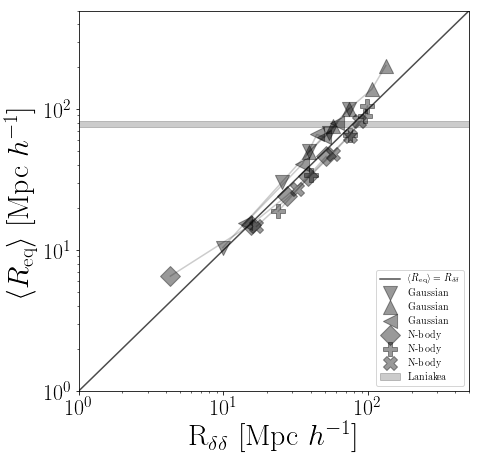

In [25]:
plt.figure(figsize=(7,7))

markers=["v", "^", "<", "D", "P", "X"]
x_gauss = []
y_gauss = []
x_nbody = []
y_nbody = []
for i, experiment in enumerate(all_data.keys()):
    if "gauss" in experiment:
        label = "Gaussian"
        print(experiment)
        x_gauss += list(all_data[experiment]["lengths"][:,1])
        y_gauss += list(all_data[experiment]["watershed"][:,1])
    else:
        label = "N-body"
        x_nbody += list(all_data[experiment]["lengths"][:,1])
        y_nbody += list(all_data[experiment]["watershed"][:,1])
        
    
    plt.scatter(all_data[experiment]["lengths"][:,1], all_data[experiment]["watershed"][:,1], marker=markers[i], 
                s=200, label=label, color='black', alpha=0.4)
    plt.plot(all_data[experiment]["lengths"][:,1], all_data[experiment]["watershed"][:,1], color='black', alpha=0.2)
    #plt.plot(length_data[k][:,0], length_data[k][:,1], color='black')


def func(x, a):
    return a * x
popt, pcov = curve_fit(func, x_gauss, y_gauss)
print(popt, np.sqrt(pcov))
popt, pcov = curve_fit(func, x_nbody, y_nbody)
print(popt, np.sqrt(pcov))

x = np.linspace(0,500,100)
plt.plot(x, x, 
         label=r'$\langle R_{\mathrm{eq}} \rangle = R_{\delta\delta}$', 
        color='black', alpha=0.7)

#print(laniakea_radius_min, laniakea_radius_max)
dd = np.linspace(1E-3,500)
plt.fill_between(dd, laniakea_radius_min*dd/dd, laniakea_radius_max*dd/dd, label='Laniakea', color='black', alpha=0.2)
plt.loglog()
plt.legend(loc=4)
plt.xlim(1,500)
plt.ylim(1,500)
plt.xlabel(r"R$_{\delta\delta}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"$\langle R_{\mathrm{eq}} \rangle$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.savefig("summary_watershed.pdf", bbox_inches='tight')

In [133]:
filename = '../data/watershed_mock_divergence_mesh_100_box_1000_slim_15.h5'
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_gauss = (3.0*(cluster_n_size*(1000/100)**3)/(4.0*np.pi))**(1/3)

sigma=40
path = "../data/"
filename = path+"watershed_mock_AbacusCosmos_720box_planck_00_0_FoF_vmax_200.0_s_{:.1f}_nside_144.hdf5".format(sigma)
f = h5py.File(filename, 'r')
watershed = f['watershed_group'][...]
f.close()
counts = Counter(watershed.flatten())
clusters = np.array(list(counts.items()))
cluster_n_size = clusters[:,1]
cluster_radius_abacus = (3.0*(cluster_n_size*(720/144)**3)/(4.0*np.pi))**(1/3)

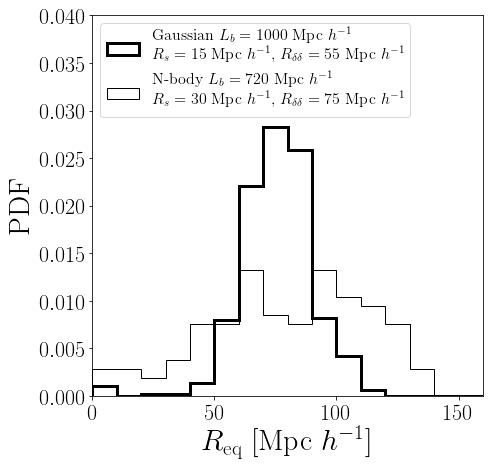

In [144]:
plt.figure(figsize=(7,7))

_ = plt.hist(cluster_radius_gauss, bins=np.arange(0,180,10), 
             color='black', histtype='step', linewidth=3, 
             label='Gaussian $L_{b}=1000$ Mpc $h^{-1}$ \n $R_{s}=15$ Mpc $h^{-1}$, $R_{\delta\delta}=55$ Mpc $h^{-1}$', density=True)
_ = plt.hist(cluster_radius_abacus, bins=np.arange(0,180,10),
             color='black', histtype='step', 
             label='N-body $L_{b}=720$ Mpc $h^{-1}$ \n $R_{s}=30$ Mpc $h^{-1}$, $R_{\delta\delta}=75$ Mpc $h^{-1}$', density=True)
plt.legend(loc=2)
plt.xlabel(r"$R_{\mathrm{eq}}$ [$\mathrm{Mpc}\ h^{-1}$]")
plt.ylabel(r"PDF")
plt.ylim([0,0.04])
plt.xlim([0,160])
plt.savefig("sizes_histogram.pdf", bbox_inches='tight')

In [23]:
cluster_radius_abacus

array([ 4.18736581, 14.18223937, 31.5017901 , 39.23753844, 12.74327926,
       35.0967697 , 32.38820023, 51.75473458, 53.47617838, 29.64019302,
       59.87665407, 43.03579798, 58.10744237, 44.76587594, 75.62954874,
       89.93094892, 47.72415797, 13.76924284, 12.74885863, 42.52266936,
       26.15806458, 39.07792635, 33.74747964, 29.74710918, 27.3131355 ,
       49.74251009, 34.06990974, 74.65706967, 62.52289212, 35.1305873 ,
       52.50422571, 34.59058173, 32.21444977, 54.54108464, 20.24197705,
       67.53532673, 62.76035965, 30.73616087, 47.74643445, 53.91224897,
        1.75858344, 18.83197067, 10.71188233])

In [ ]:
cluster_radius_abacus